# Personalized Medicine: Redefining Cancer Treatment

### Context
Kaggle Competition: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

### Problem Statement
Develop a Machine Learning algorithm that automatically classifies genetic variations that contribute to tumor growth.

#### There are nine different classes a genetic mutation can be classified on:
    1. Likely Loss-of-function
    2. Likely Gain-of-function
    3. Neutral
    4. Loss-of-function
    5. Likely Neutral
    6. Inconclusive
    7. Gain-of-function
    8. Likely Switch-of-function
    9. Switch-of-function
    
Therefore, the machine learning problem is a Multi Class Classification.

### Performance Metrics
* Multi class log-loss
* Confusion matrix

### Data
Provides information about the genetic mutations and clinical evidence (text):

    - Gene (the gene where this genetic mutation is located)
    - Variation (the aminoacid change for this mutations)
    - Class (1-9 the class this genetic mutation has been classified on)
    - Text (the clinical evidence used to classify the genetic mutation)

## Explorying the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Overview

In [2]:
df_train = pd.read_csv('df_train')
df_test = pd.read_csv('df_test')

In [5]:
df_train.head()

,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [6]:
df_test.head()

,ID,Text,Gene,Variation
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A


In [7]:
print('Training Features')
print('')
df_train.info()
print('')
print('')
print('Test Features')
print('')
df_test.info()

Training Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3316 non-null   int64 
 1   Text       3316 non-null   object
 2   Gene       3316 non-null   object
 3   Variation  3316 non-null   object
 4   Class      3316 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 129.7+ KB


Test Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5667 entries, 0 to 5666
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5667 non-null   int64 
 1   Text       5667 non-null   object
 2   Gene       5667 non-null   object
 3   Variation  5667 non-null   object
dtypes: int64(1), object(3)
memory usage: 177.2+ KB


In [8]:
print('Training data:')
print('')
print('IDs:', len(df_train.ID.unique()))
print('Unique genes:', len(df_train.Gene.unique()))
print('Unique variations:', len(df_train.Variation.unique()))
print('Unique classes:', len(df_train.Class.unique()))
print('Unique texts:', len(df_train.Text.unique()))

Training data:

IDs: 3316
Unique genes: 262
Unique variations: 2993
Unique classes: 9
Unique texts: 1920


In [9]:
print('Test data:')
print('')
print('IDs:', len(df_test.ID.unique()))
print('Unique genes:', len(df_test.Gene.unique()))
print('Unique variations:', len(df_test.Variation.unique()))

Test data:

IDs: 5667
Unique genes: 1396
Unique variations: 5628


In [10]:
# Checking for missing values in training set
((df_train.isnull().sum()/len(df_train))*100).sort_values(ascending=False)

Class        0.0
Variation    0.0
Gene         0.0
Text         0.0
ID           0.0
dtype: float64

In [11]:
# Checking for missing values in test set
((df_test.isnull().sum()/len(df_test))*100).sort_values(ascending=False)

Variation    0.0
Gene         0.0
Text         0.0
ID           0.0
dtype: float64

In [12]:
# Checking for duplicates
print('Training duplicated rows: ', df_train.duplicated().sum())
print('Test duplicated rows: ', df_test.duplicated().sum())

Training duplicated rows:  0
Test duplicated rows:  0


## Exploratory Analysis

#### Dependent Variable (Class)

In [13]:
# Cheking the distribution of the target variable in %
(df_train['Class'].value_counts()/len(df_train)*100).sort_values(ascending=False)

7    28.709288
4    20.687575
1    17.068758
2    13.630881
6     8.232811
5     7.297949
3     2.683957
9     1.115802
8     0.572979
Name: Class, dtype: float64

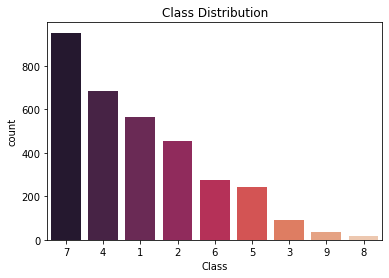

In [15]:
sns.countplot(df_train.Class, palette='rocket', order=df_train.Class.value_counts().index)
plt.title('Class Distribution');

We have an unbalanced class problem. Most of cases result in class 7 and very few examples for classes 8 and 9.

#### Independent Variables

In [3]:
# Checking categories
def check_var(df, variable):
    
    most_freq = df[variable].value_counts().head(30)
    less_freq = df[variable].value_counts().tail(30)
    unique = df[variable].unique()
    
    return print('\033[1m' + 'MOST FREQUENT VALUES: \n\n' + '\033[0m', most_freq, '\n\n', 
                 '\033[1m' + 'LESS FREQUENT VALUES: \n\n' + '\033[0m', less_freq, '\n\n',
                 '\033[1m' + 'UNIQUE VALUES: \n\n' + '\033[0m', unique)

# Variable distribution
def plot_distribution(df, variable):
    
    distribution = df.groupby(variable)[variable].count()

    for i in [2, 5, 10, 20, 50, 100, 300]:
        print('{} occuring less than {} times: {}'.format(variable, i, round((distribution < i).mean() * 100, 2)))

    plt.hist(distribution.values, bins=50, log=True)
    plt.xlabel('Number of times occured', fontsize=12)
    plt.ylabel('log of Count', fontsize=12)
    
# Plotting variable + target (Class)
def plotting_var_class(df, variable):
    
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

    for i in range(3):
        for j in range(3):
            gene_count_grp = df[df["Class"]==((i*3+j)+1)].groupby(variable)["ID"].count().reset_index()
            sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
            sorted_gene_group_top_7 = sorted_gene_group[:7]
            sns.barplot(x=variable, y="ID", data=sorted_gene_group_top_7, ax=axs[i][j], palette='rocket')
            
# Most frequent values per class
def most_freq(variable):
    
    var_class = df_train.groupby('Class')[variable].value_counts()
    return var_class.sort_values(ascending=False).head(20)

### Gene Variable

In [28]:
print('\033[1m' + 'TRAINING SET - GENE VARIABLE' + '\033[0m')
print('')
check_var(df_train, 'Gene')

TRAINING SET - GENE VARIABLE

MOST FREQUENT VALUES: 

 BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       92
ALK        69
ERBB2      69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
MTOR       45
KRAS       44
MAP2K1     43
VHL        41
RET        40
FGFR3      38
MLH1       35
JAK2       33
SMAD4      33
MET        33
NOTCH1     31
AKT1       28
ROS1       26
ABL1       26
PTPN11     26
Name: Gene, dtype: int64 

 LESS FREQUENT VALUES: 

 RRAS2     1
CDK8      1
BCL2      1
SDHB      1
EPCAM     1
ARID1A    1
ATR       1
TCF7L2    1
ASXL1     1
FGF4      1
MEN1      1
INPP4B    1
IKZF1     1
HLA-B     1
RAD51D    1
AXIN1     1
CDKN2C    1
SRSF2     1
KMT2B     1
SHOC2     1
CTLA4     1
GNAQ      1
PAK1      1
RYBP      1
RARA      1
GLI1      1
KDM5A     1
AURKB     1
SDHC      1
NCOR1     1
Name: Gene, dtype: int64 

 UNIQUE VALUES: 

 ['FAM58A' 'CBL' 'SHOC2' 'TERT' 'DICER1' 'PTPRT' 'RHEB' 'SHQ1' 'CCN

##### Distribution on Training Data

Gene occuring less than 2 times: 26.34
Gene occuring less than 5 times: 52.67
Gene occuring less than 10 times: 71.37
Gene occuring less than 20 times: 82.82
Gene occuring less than 50 times: 95.04
Gene occuring less than 100 times: 98.09
Gene occuring less than 300 times: 100.0


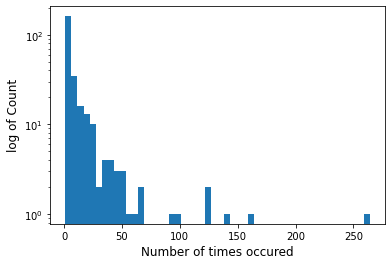

In [24]:
plot_distribution(df_train, 'Gene')

##### Distribution on Test Data

Gene occuring less than 2 times: 35.32
Gene occuring less than 5 times: 73.14
Gene occuring less than 10 times: 91.4
Gene occuring less than 20 times: 98.21
Gene occuring less than 50 times: 99.79
Gene occuring less than 100 times: 99.93
Gene occuring less than 300 times: 100.0


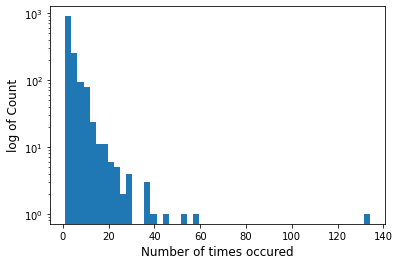

In [32]:
plot_distribution(df_test, 'Gene')

##### Evaluating Gene + Target Variable (Class)

In [41]:
most_freq('Gene')

Class  Gene  
4      PTEN      115
5      BRCA1      90
7      EGFR       84
6      BRCA2      84
1      TP53       83
4      TP53       67
1      BRCA1      60
6      BRCA1      53
7      KIT        52
       ALK        47
       BRAF       47
4      CDKN2A     47
       BRCA1      46
2      EGFR       45
       KIT        44
7      PDGFRA     42
       FLT3       37
       KRAS       33
       PIK3CA     31
2      BRAF       31
Name: Gene, dtype: int64

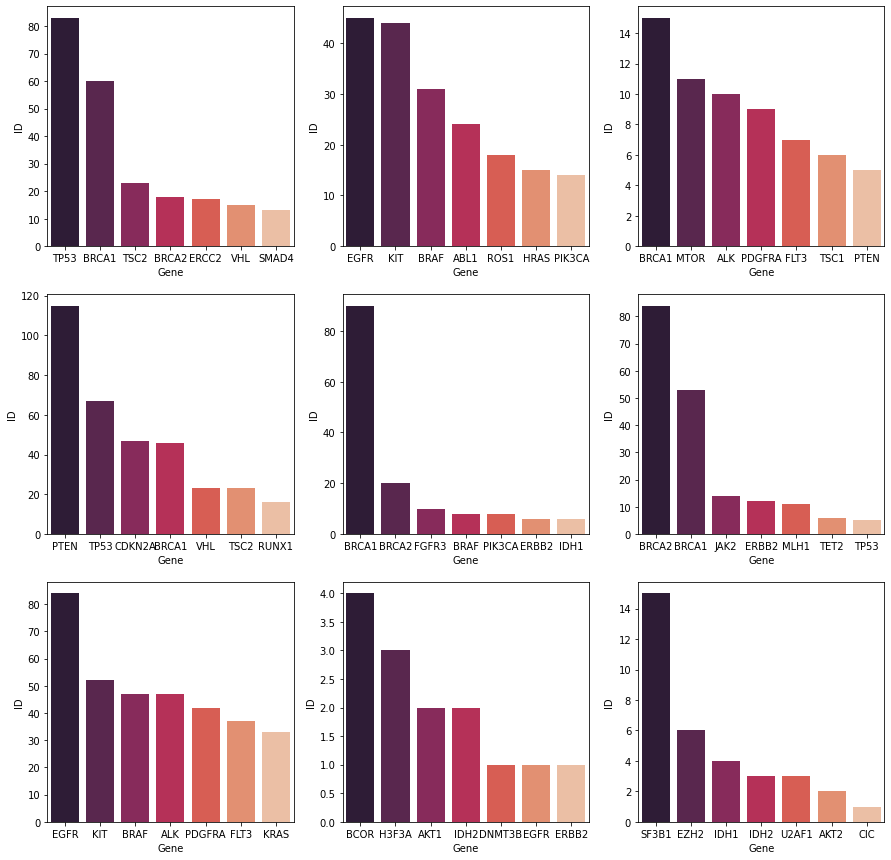

In [36]:
plotting_var_class(df_train, 'Gene')

**Some conclusions:**
- BRCA1 is the most common gene affected
- PTEN is mostly involved in Class 4
- BRCA1 is highly dominating Class 9
- SF3B1 is highly dominating Class 9

### Variation Variable

In [30]:
print('\033[1m' + 'TRAINING SET - VARIATION VARIABLE' + '\033[0m')
print('')
check_var(df_train, 'Variation')

TRAINING SET - VARIATION VARIABLE

MOST FREQUENT VALUES: 

 Truncating Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
G12V                     4
T58I                     3
E17K                     3
Q61H                     3
Q61L                     3
Q61R                     3
C618R                    2
G12D                     2
Y64A                     2
ETV6-NTRK3 Fusion        2
P34R                     2
G13D                     2
G12S                     2
G13V                     2
R170W                    2
T73I                     2
A146V                    2
G67R                     2
G12C                     2
M1R                      2
K117N                    2
S308A                    2
G35R                     2
Q61K                     2
F384L                    2
Name: Variation, dtype: int64 

 LESS FREQUENT VALUES: 

 CCDC6-ROS1 Fusion     1
L790F                 1
G660D                 1


##### Distribution on Training Data

Variation occuring less than 2 times: 98.33
Variation occuring less than 5 times: 99.83
Variation occuring less than 10 times: 99.87
Variation occuring less than 20 times: 99.87
Variation occuring less than 50 times: 99.9
Variation occuring less than 100 times: 100.0
Variation occuring less than 300 times: 100.0


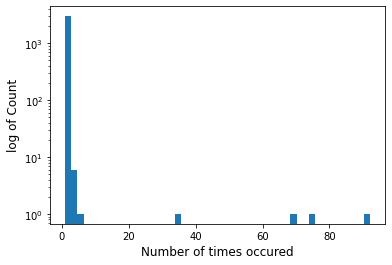

In [31]:
plot_distribution(df_train, 'Variation')

##### Distribution on Test Data

Variation occuring less than 2 times: 99.91
Variation occuring less than 5 times: 99.95
Variation occuring less than 10 times: 99.96
Variation occuring less than 20 times: 100.0
Variation occuring less than 50 times: 100.0
Variation occuring less than 100 times: 100.0
Variation occuring less than 300 times: 100.0


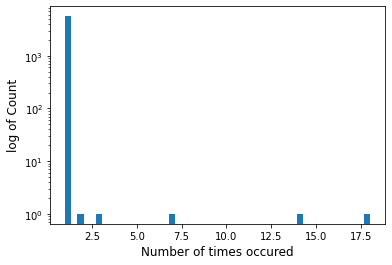

In [33]:
plot_distribution(df_test, 'Variation')

##### Evaluating Variation + Target Variable (Class)

In [42]:
most_freq('Variation')

Class  Variation           
1      Truncating Mutations    88
       Deletion                57
7      Amplification           40
2      Fusions                 31
       Amplification           21
4      Deletion                16
6      Amplification            9
7      Overexpression           4
       G12V                     4
       E17K                     3
       Q61L                     3
       Q61R                     3
       A146T                    2
       E542K                    2
       ETV6-NTRK3 Fusion        2
       F28L                     2
       G12D                     2
2      G13V                     2
       Overexpression           2
7      EWSR1-ETV1 Fusion        2
Name: Variation, dtype: int64

**Some points we can conclude:**
- Most of variations occur 1-2 times only.
- Most commum variations include: Truncating mutations, deletion, and amplification.

### Exploring Text Data

In [55]:
# Creating a new column with text lenght
df_train.loc[:, 'Text_count'] = df_train["Text"].apply(lambda x: len(x.split()))
df_train.head()

,ID,Text,Gene,Variation,Class,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,6089
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,5756
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,5756
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,6202


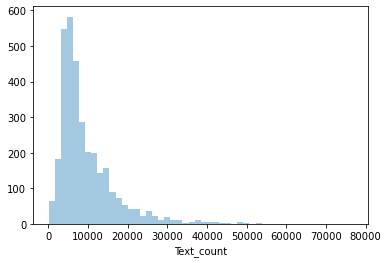

In [57]:
sns.distplot(df_train.Text_count, bins=50, kde=False)

The peak is around 4000.

In [62]:
# Checking text distribution per class
count_txt = df_train.groupby('Class')["Text_count"]
count_txt.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,566.0,9483.689046,6503.595573,183.0,4976.00,7317.0,12944.50,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.00,6810.0,12220.00,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.00,5572.0,7415.00,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.00,6351.0,11537.00,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.00,6463.0,9513.50,24226.0
6,273.0,7236.743590,3801.049711,230.0,4691.00,6587.0,7847.00,24609.0
7,952.0,11454.886555,10110.443171,448.0,4876.25,8256.5,14647.25,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.00,11253.0,15535.00,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.00,10930.0,15797.00,45177.0


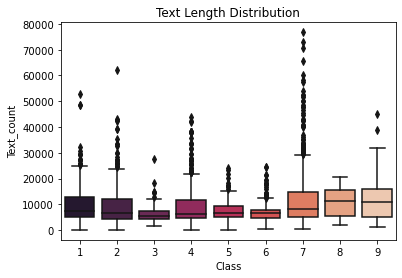

In [58]:
sns.boxplot(x='Class', y='Text_count', data=df_train, palette='rocket')
plt.title('Text Length Distribution');

Most of classes have most counts between 5000 and 15000, with exception of classes 3, 5, and 6.

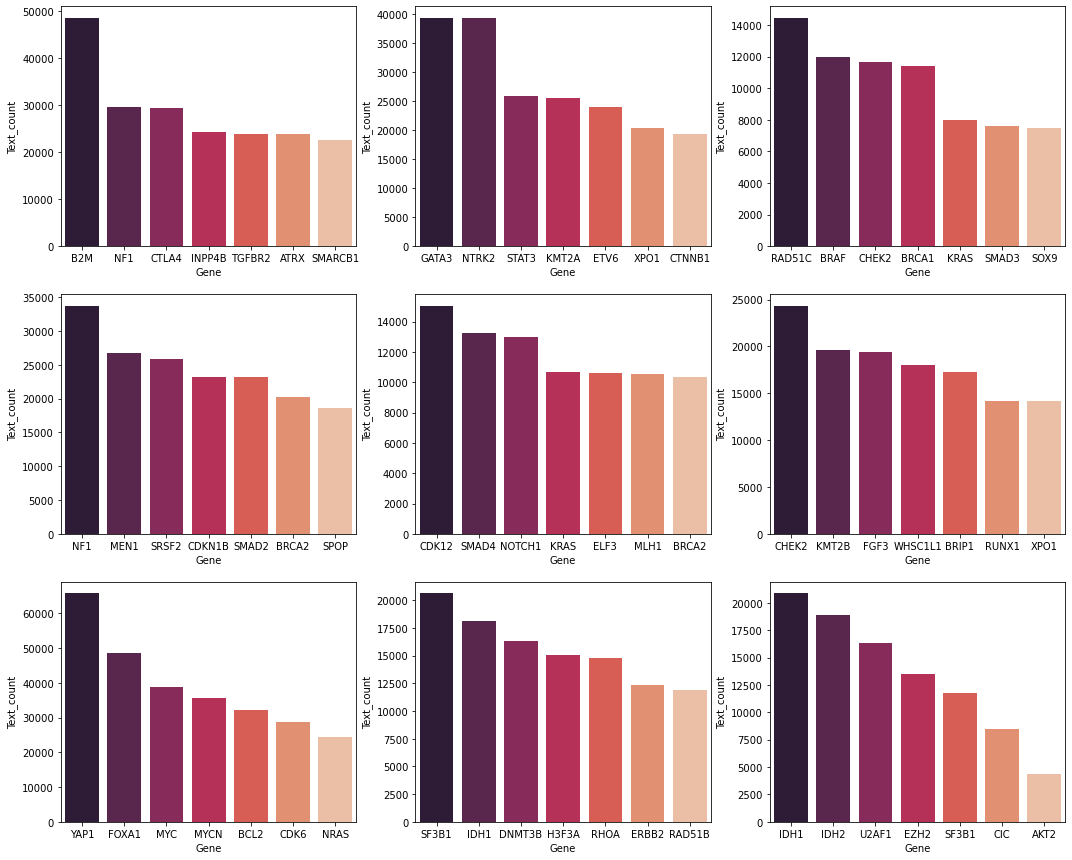

In [61]:
# Text lenght distribution per gene and class
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_train[df_train["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j], palette='rocket')

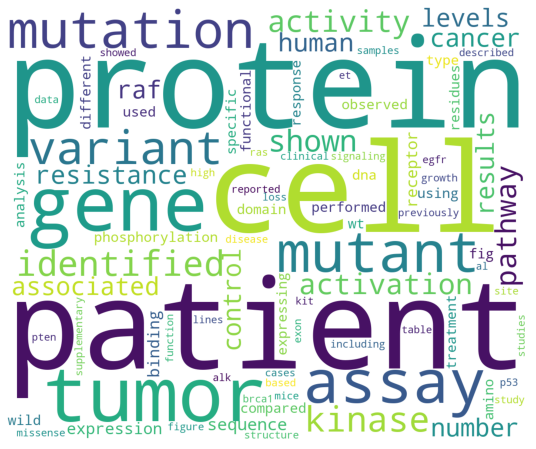

In [63]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

count = TfidfVectorizer(stop_words ='english', analyzer='word', max_features=100)
count.fit_transform(df_train['Text'])
vocab = count.vocabulary_.keys()

wc = WordCloud(background_color='white',
                          width=1200,
                          height=1000
                         ).generate(' '.join(vocab))
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.axis('off')

wc.to_file("wordCloud.png");

These are the most occuring words found in training set.